In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import os

/Users/Nathalie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



File: /Users/Nathalie/Desktop/DISS/data/background_for_training.h5
  Particles: shape=(13451915, 19, 4), dtype=float64
  Particles_Classes: shape=(4,), dtype=|S16
  Particles_Names: shape=(4,), dtype=|S5

File: /Users/Nathalie/Desktop/DISS/data/Ato4l_lepFilter_13TeV_filtered.h5
  Particles: shape=(55969, 19, 4), dtype=float64
  Particles_Classes: shape=(4,), dtype=|S16
  Particles_Names: shape=(4,), dtype=|S5

File: /Users/Nathalie/Desktop/DISS/data/hChToTauNu_13TeV_PU20_filtered.h5
  Particles: shape=(760272, 19, 4), dtype=float64
  Particles_Classes: shape=(368,), dtype=|S16
  Particles_Names: shape=(368,), dtype=|S5

File: /Users/Nathalie/Desktop/DISS/data/hToTauTau_13TeV_PU20_filtered.h5
  Particles: shape=(691283, 19, 4), dtype=float64
  Particles_Classes: shape=(388,), dtype=|S16
  Particles_Names: shape=(388,), dtype=|S5

File: /Users/Nathalie/Desktop/DISS/data/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
  Particles: shape=(340544, 19, 4), dtype=float64
  Particles_Classes: 

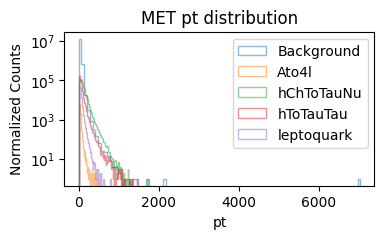

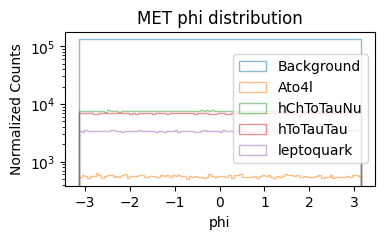

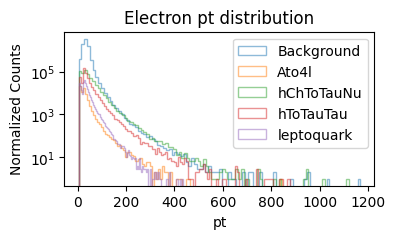

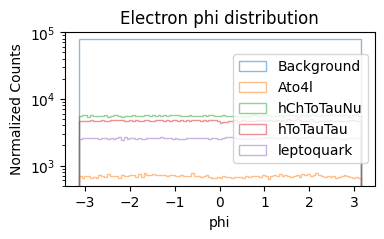

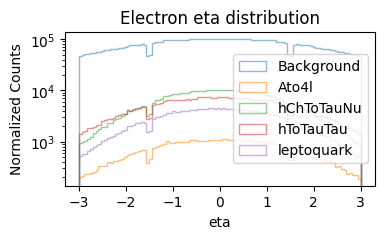

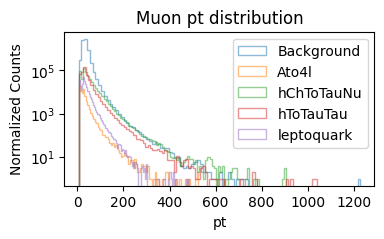

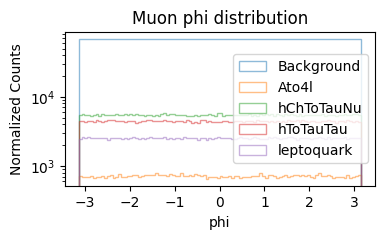

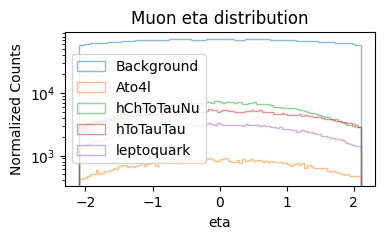

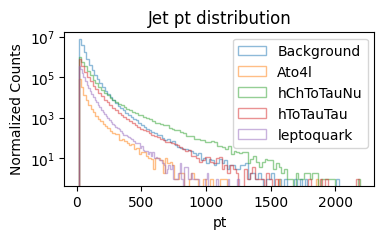

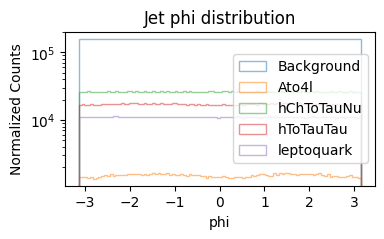

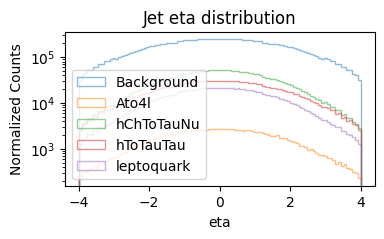

In [2]:
# Define particle type indexes and names
particle_types = {1: 'MET', 2: 'Electron', 3: 'Muon', 4: 'Jet'}

# Load particles from file
def load_particles(file_path):
    with h5py.File(file_path, 'r') as f:
        particles = f['Particles'][:]
    return particles

# printing out sanity check of datach
def check_data(file_dict): 
    for name, file in file_dict.items(): 
        print(f"\nFile: {file}")
        with h5py.File(file, "r") as f:  # "r" to read-only file 
            for key in f.keys():
                data = f[key][:]
                print(f"  {key}: shape={data.shape}, dtype={data.dtype}")

# Extract features for a given particle type and filter out padding
def extract_features(particles, type_id):
    mask = particles[..., 3] == type_id  # select particle type
    pt = particles[..., 0][mask] # transverse momentum
    eta = particles[..., 1][mask] # pseudorapidity
    phi = particles[..., 2][mask] # azimuthal angle
    return pt, eta, phi

# function to process multiple files
def process_files(file_dict):
    """
    file_dict: dict with key = label (name of dataset), value = file_path
    returns: nested dict: data[label][particle][feature] = array
    """
    data = {}

    for label, file_path in file_dict.items():
        particles = load_particles(file_path)
        data[label] = {}

        for type_id, name in particle_types.items():
            pt, eta, phi = extract_features(particles, type_id)
            data[label][name] = {'pt': pt, 'eta': eta, 'phi': phi}

    return data

# Plotting function
def plot_feature(data, particle, feature, bins=100):
    plt.figure(figsize=(4,2))

    for label in data.keys():
        values = data[label][particle][feature]
        plt.hist(values, bins=bins, alpha=0.5, label=label, histtype='step') # density=True to normalise 
        plt.yscale("log")

    plt.title(f"{particle} {feature} distribution")
    plt.xlabel(feature)
    plt.ylabel('Normalized Counts')
    plt.legend()
    plt.show()


file_dict = {
    'Background': '/Users/Nathalie/Desktop/DISS/data/background_for_training.h5',
    'Ato4l': '/Users/Nathalie/Desktop/DISS/data/Ato4l_lepFilter_13TeV_filtered.h5',
    'hChToTauNu': '/Users/Nathalie/Desktop/DISS/data/hChToTauNu_13TeV_PU20_filtered.h5',
    'hToTauTau' : '/Users/Nathalie/Desktop/DISS/data/hToTauTau_13TeV_PU20_filtered.h5', 
    'leptoquark': '/Users/Nathalie/Desktop/DISS/data/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
}

# Load and process all datasets

data = process_files(file_dict) #just change this to combined files once combined and should still be able to extract features
check_data(file_dict)

# MET pt
plot_feature(data, particle='MET', feature='pt')
plot_feature(data, particle='MET', feature='phi')

# Electron eta
plot_feature(data, particle='Electron', feature='pt')
plot_feature(data, particle='Electron', feature='phi')
plot_feature(data, particle='Electron', feature='eta')

# Muon phi
plot_feature(data, particle='Muon', feature='pt')
plot_feature(data, particle='Muon', feature='phi')
plot_feature(data, particle='Muon', feature='eta')

plot_feature(data, particle='Jet', feature='pt')
plot_feature(data, particle='Jet', feature='phi')
plot_feature(data, particle='Jet', feature='eta')

In [3]:
background_file = "/Users/Nathalie/Desktop/DISS/data/background_for_training.h5" # background data file

signal_files = [ # signal data files
    "/Users/Nathalie/Desktop/DISS/data/Ato4l_lepFilter_13TeV_filtered.h5",
    "/Users/Nathalie/Desktop/DISS/data/hChToTauNu_13TeV_PU20_filtered.h5",
    "/Users/Nathalie/Desktop/DISS/data/hToTauTau_13TeV_PU20_filtered.h5",
    "/Users/Nathalie/Desktop/DISS/data/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"
]

output_names = [ # names for output files
    "Ato4l_lepFilter",
    "hChToTauNu",
    "hToTauTau",
    "leptoquark_LOWMASS"
]

output_folder = '/Users/Nathalie/Desktop/DISS/data/combined_datasets/'
model_output = "/Users/Nathalie/Desktop/DISS/data/models/"

os.makedirs(model_output, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)


In [4]:
def remove_padding(particles): 
    padding_mask = particles[:, :, 3] != 0  # filter out padding
    valid_features = particles[:, :, :3][padding_mask]  # take pT, η, φ
    return valid_features

def combine_signal_background(signal_path, background_path, output_path):
    # Load background particles
    background_particles = load_particles(background_path)

    # Load signal particles
    signal_particles = load_particles(signal_path)

    # Combine particles along event axis
    combined_particles = np.concatenate([signal_particles, background_particles], axis=0)

    # Save combined dataset
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('Particles', data=combined_particles)

# Combine each signal with background
for output_name, signal_path in zip(output_names, signal_files):
    output_path = os.path.join(output_folder, f'{output_name}_with_background.h5')
    combine_signal_background(signal_path, background_file, output_path)
    print(f"Saved: {output_path}")

Saved: /Users/Nathalie/Desktop/DISS/data/combined_datasets/Ato4l_lepFilter_with_background.h5
Saved: /Users/Nathalie/Desktop/DISS/data/combined_datasets/hChToTauNu_with_background.h5
Saved: /Users/Nathalie/Desktop/DISS/data/combined_datasets/hToTauTau_with_background.h5
Saved: /Users/Nathalie/Desktop/DISS/data/combined_datasets/leptoquark_LOWMASS_with_background.h5


In [ ]:
all_features = []

for name, filepath in file_dict.items():
    data = load_particles(filepath)
    data = data[:, :, :-1]
    data= data.reshape(data.shape[0], 57)
    all_features.append(data)

# Combine everything
combined_features = np.vstack(all_features)

# Fit scaler
scaler = StandardScaler()
scaler.fit(combined_features)

# scaler is now ready to be used on any dataset

In [8]:
def create_supervised_dataset(bkg_file, signal_file, scaler, output_path, events = None, test_size=0.2, val_size=0.2, input_shape=57, random_num=42):
    # load and process background file 
    with h5py.File(bkg_file, 'r') as file:
        bkg_data = file['Particles'][:, :, :-1] # remove the last feature (label)
        np.random.shuffle(bkg_data) # shuffle data to remove bias and ensure randomness
        if events: # if events not None 
            bkg_data = bkg_data[:events, :, :]
        bkg_data_flattened = bkg_data.reshape(bkg_data.shape[0], input_shape)
        y_bkg = np.zeros(bkg_data.shape[0]) #0's for background events

    # load and process signal file
    with h5py.File(signal_file, 'r') as file:
        sig_data = file['Particles'][:, :, :-1] #drop last feature
        if events: # if events not None
            sig_data = sig_data[:events, :, :] 
        sig_data_flattened = sig_data.reshape(sig_data.shape[0], input_shape)
        y_sig = np.ones(sig_data.shape[0]) # 1's for signal events 

        # Subsample background to match signal size
        n_signal = sig_data.shape[0]
        if bkg_data.shape[0] > n_signal:
            indices = np.random.choice(bkg_data.shape[0], size=n_signal, replace=False)
            bkg_data_balanced = bkg_data[indices]
            bkg_data_flat_balanced = bkg_data_flattened[indices]
            y_bkg_balanced = y_bkg[indices]
        else:
            bkg_data_balanced = bkg_data
            bkg_data_flat_balanced = bkg_data_flattened
            y_bkg_balanced = y_bkg

    # Combine balanced datasets
    X = np.vstack((bkg_data_balanced, sig_data))  # shape: (n_events, 19, 3)
    X_flattened = np.vstack((bkg_data_flat_balanced, sig_data_flattened))  # shape: (n_events, 57)
    y = np.concatenate((y_bkg_balanced, y_sig))

    # Normalise using provided global scaler
    X_flat_scaled = scaler.transform(X_flattened)

    # Train/val/test splitting
    X_train, X_test, y_train, y_test = train_test_split(X_flat_scaled, y, test_size=test_size, stratify=y, random_state=random_num)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=random_num)

    with h5py.File(output_path, 'w') as h5f:
        h5f.create_dataset('X_train', data=X_train)
        h5f.create_dataset('y_train', data=y_train)
        h5f.create_dataset('X_val', data=X_val)
        h5f.create_dataset('y_val', data=y_val)
        h5f.create_dataset('X_test', data=X_test)
        h5f.create_dataset('y_test', data=y_test)
        #h5f.create_dataset('X', data=X) # save the raw data (shape: (n_events, 19, 3)) for plotting combined distributions 

In [9]:
# create the combined datasets for each signal file 
for signal_file, output_name in zip(signal_files, output_names):
    output_path = f"{output_folder}/{output_name}_dataset.h5"
    create_supervised_dataset(background_file, signal_file, scaler, output_path, events= 10000, test_size=0.2, val_size=0.2, input_shape=57, random_num=42)

ValueError: X has 57 features, but StandardScaler is expecting 3 features as input.

In [ ]:
# create supervised binary classifier NN 
def build_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
for output_name in output_names:
    file_path = f"{output_folder}/{output_name}_dataset.h5"
    with h5py.File(file_path, 'r') as f:
        X_train = f['X_train'][:]
        y_train = f['y_train'][:]
        X_val = f['X_val'][:]
        y_val = f['y_val'][:]

    model = build_model(input_dim=57)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=128, callbacks=[early_stop])
    
    # Save the model
    model.save(f"{model_output}/{output_name}_model.h5")

    # Plot training
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"{output_name} Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Validation Acc')
    plt.legend()
    plt.title(f"{output_name} Accuracy")
    plt.grid()
    plt.show()



In [ ]:
# cross testing models (ROC CURVES)

for test_name in output_names:
    with h5py.File(f"{output_folder}/{test_name}_dataset.h5", 'r') as f:
        X_test = f['X_test'][:]
        y_test = f['y_test'][:]

    plt.figure(figsize=(8,6))
    
    for train_name in output_names:
        model = load_model(f"{model_output}/{train_name}_model.h5")
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"Model [{train_name}] AUC: {auc:.3f}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves: All models tested on [{test_name}] dataset")
    plt.legend()
    plt.grid()
    plt.show()
